# Modelado para la Predicción del Precio de la Vivienda

En este notebook, realizamos la fase de modelado para predecir el precio de las viviendas utilizando varios algoritmos de machine learning.
Los pasos incluyen:
1. Preprocesamiento de datos para el modelado.
2. Entrenamiento de múltiples modelos y evaluación de su rendimiento.
3. Selección del modelo ganador.
4. Identificación de las variables más relevantes en el modelo ganador.


In [2]:

import pandas as pd

# Cargar el dataset limpio
file_path = '../data/processed/cleaned_ofertas_inmobiliarias.csv'
df = pd.read_csv(file_path)

# Mostrar las primeras filas
df.head()



,Precio,Habitaciones,Baños,Parqueos,Sector,Condicion,Uso Actual,mt2,Terreno mt2,Piso/Nivel,Ascensor,Edificable,Agno Construccion,Planta Electrica,Seguridad 24 Horas,Control de Acceso,Piscina,Gimnasio
0,950.0,1,2.0,1,El Millón,Segundo Uso,Residencial,73.00,0.0,5,True,No,2024,False,False,False,True,True
1,10640.0,4,4.5,5,Av. Anacaona,Segundo Uso,Residencial,608.84,0.0,0,True,No,2020,True,True,True,True,True
2,10640.0,3,4.5,4,Av. Anacaona,Segundo Uso,Residencial,598.00,598.0,0,True,No,2024,True,True,True,True,True
3,10640.0,3,4.5,2,Av. Anacaona,Segundo Uso,Residencial,598.00,0.0,0,True,No,2024,True,True,True,True,True
4,10640.0,4,4.5,4,Av. Anacaona,Nueva,Residencial,608.84,0.0,14,True,No,2023,True,True,True,True,False


In [3]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Seleccionar variables predictoras y variable objetivo
X = df.drop('Precio', axis=1)
y = df['Precio']

# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificar columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# Preprocesamiento: Escalado de variables numéricas y codificación de variables categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Aplicar el preprocesador a los datos
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train.shape, X_test.shape


((778, 79), (195, 79))

In [4]:

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Definir modelos
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0)
}

# Entrenar y evaluar modelos
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R²': r2}

# Mostrar resultados
results



{'Linear Regression': {'RMSE': np.float64(1216.5530269667079),
  'R²': 0.2882924882602389},
 'Decision Tree': {'RMSE': np.float64(1011.9103768744588),
  'R²': 0.507593744743771},
 'Random Forest': {'RMSE': np.float64(1065.8124593581265),
  'R²': 0.4537379276002138},
 'XGBoost': {'RMSE': np.float64(1045.2479912050949), 'R²': 0.4746144239543635}}

In [8]:

# Selección del mejor modelo basado en RMSE
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
best_model = models[best_model_name]

# Entrenar el modelo ganador con todo el conjunto de datos
best_model.fit(X_train, y_train)

# Importancia de las características
importances = best_model.feature_importances_ if hasattr(best_model, 'feature_importances_') else None

if importances is not None:
    # Ranking de las variables más importantes
    feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out())
    feature_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
    feature_importances
else:
    "El modelo seleccionado no proporciona importancias de características."


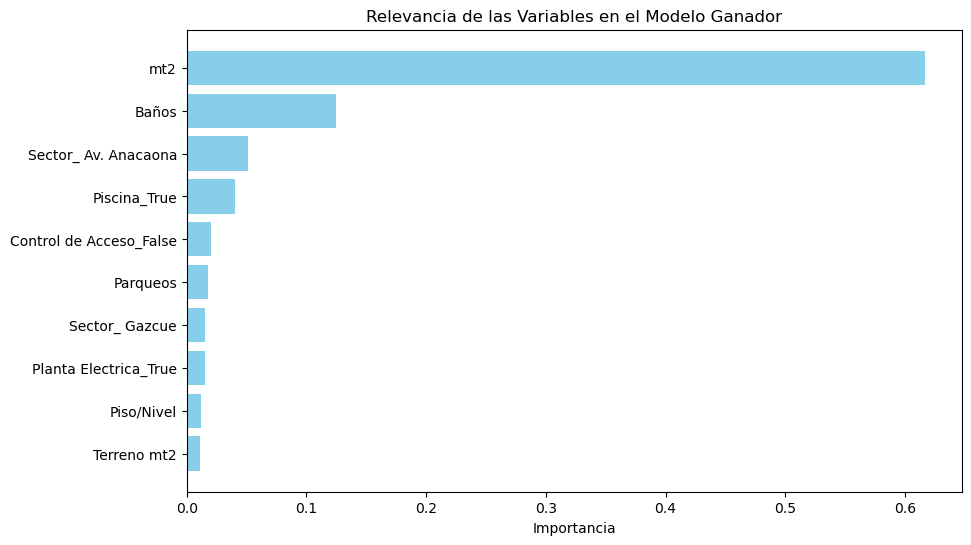

In [11]:
import matplotlib.pyplot as plt

# Lista de importancias de características (se puede modificar para tomar directamente del modelo)

top = feature_importances[:10]
# Separar los nombres de las características y sus valores de importancia
features = [feature[0] for feature in top]
importances = [feature[1] for feature in top]

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importancia')
plt.title('Relevancia de las Variables en el Modelo Ganador')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar las características más importantes en la parte superior
plt.show()